In [54]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt2",          # --job-name
    cores=2,                     # Number of cores per task (adjust if needed)
    processes=1,                 # One process per task
    memory="20GB",               # --mem
    walltime="01:00:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)

import glob 
import os

In [56]:
data_dir = '/home1/nalex2023/Datasets/interpsonde_manus/*.nc'

all_dsets = glob.glob(data_dir)

all_dsets

['/home1/nalex2023/Datasets/interpsonde_manus/2009_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2002_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2003_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2008_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2014_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2001_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2004_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2013_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2012_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2005_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2010_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2007_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2006_MANUS_INTERPSONDEv2.nc',
 '/home1/nal

In [57]:
from dask.distributed import Client
cluster.scale(jobs=4)
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:8787/status,
Dashboard: http://10.42.239.61:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:41941,Workers: 0
Dashboard: http://10.42.239.61:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [53]:
cluster.close()

In [58]:
import xarray as xr 
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

dset = xr.open_mfdataset(all_dsets, combine='by_coords').sel(time=slice('2012'))
dset['height'] = dset['height'] * 1000
dset['time'] = dset['time'].roll(time=10)

dset = dset.sortby('time')


In [59]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from windrose import WindroseAxes


def create_dft(in_dir,arm_data=True):
    files = glob.glob(in_dir+os.sep+'*.nc')
    if len(files) == 0:
        files = glob.glob(in_dir+os.sep+'*.cdf')
        if len(files) == 0:
            raise Exception('No files Found')
        else:
            pass
    else:
        pass
    
    dft = pd.DataFrame(files,columns=['filepath'])
    dft['filename'] = dft['filepath'].str.split(os.sep).str[-1]
    
    if arm_data:
        dft['datetime'] = pd.to_datetime(dft['filename'].str.split(
            '.',
            expand=True).iloc[:, 2] + dft['filename'].str.split(
                '.',  expand=True).iloc[:, 3],format='%Y%m%d%H%M%S')


    return dft

In [6]:
#dset['u_wind'] = dset['u_wind'] - dset['u_wind'].mean(dim='time')
#dset['v_wind'] = dset['v_wind'] - dset['v_wind'].mean(dim='time')
dset

<xarray.Dataset> Size: 804MB
Dimensions:   (time: 100800, height: 332)
Coordinates:
  * height    (height) float32 1kB 4.0 24.0 44.0 ... 3.95e+04 4e+04 4.05e+04
  * time      (time) datetime64[ns] 806kB 2001-04-05 ... 2012-12-31T23:00:00
Data variables:
    bar_pres  (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    temp      (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    dp        (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    rh        (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    u_wind    (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    v_wind    (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
Attributes: (12/13)
    command_line:          idl -D 0 -R -n interpolatedsonde -s twp -f C1 -b 2...
    Conventions:           ARM-1.1
    process_version:       vap-interpolatedsonde-6.6-0.el6
    input_datastreams:     twpgriddedsondeC1.c0 : 2.2 : 20010403.000030-20010...
    dod_version:           interpolatedsonde-c1-4.0
    site_id:               twp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Tropical Western Pacific (TWP), Manus Island, Papu...
    datastream:            twpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               created by user ttoto on machine chalk at 2016-05-...

In [60]:
dset['angle'] = (90 - np.degrees(np.arctan2(-dset['u_wind'], -dset['v_wind']))) % 360



dset['speed'] = np.sqrt((dset['u_wind'] * dset['u_wind']) + 
                        (dset['v_wind'] * dset['v_wind']))

# remove the wind direction and speed if both u and v are 0
dset['angle'] = dset['angle'].where((dset['u_wind'] == 0) & (dset['v_wind'] == 0), dset['angle'])

dset['speed'] = dset['speed'].where((dset['u_wind'] == 0) & (dset['v_wind'] == 0), dset['speed'])



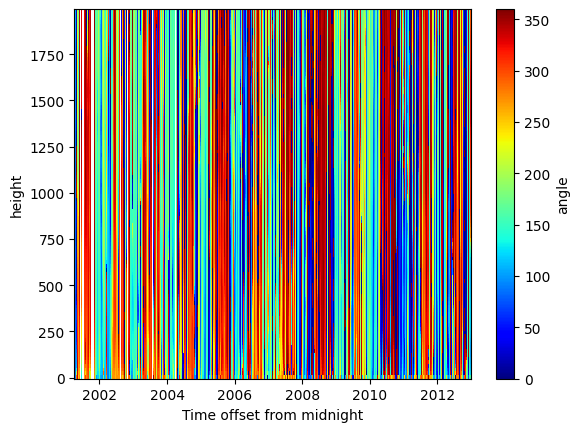

In [61]:
dset['angle'].sel(height=slice(0,2000)).plot(x='time',
                                          cmap='jet')

In [63]:
def draw_windrose(data,color=cm.Blues):
    ws = data['speed'].values
    wd = data['angle'].values
    ax = WindroseAxes.from_ax()
    ax.bar(wd,ws,normed=False,cmap=color)
    ax.set_legend()


def wind_rose_compare(data1,data2 ,cost_angle):
    ws1 = data1['speed'].values
    wd1 = data1['angle'].values
    ws2 = data2['speed'].values
    wd2 = data2['angle'].values
    
    ax = WindroseAxes.from_ax()
    
    ax.bar(wd1,ws1,normed=False,cmap=cm.Reds)
    ax.set_legend(loc='lower right')
    ax.bar(wd2,ws2,normed=False,cmap=cm.Blues)
    ax.set_legend(loc='lower left')

In [64]:
a  = dset.sel(height=10,method='nearest').compute()#.sel(hour=slice(12,19))

b = dset.sel(height=slice(500,2000)).compute()#.sel(hour=slice(12,19))

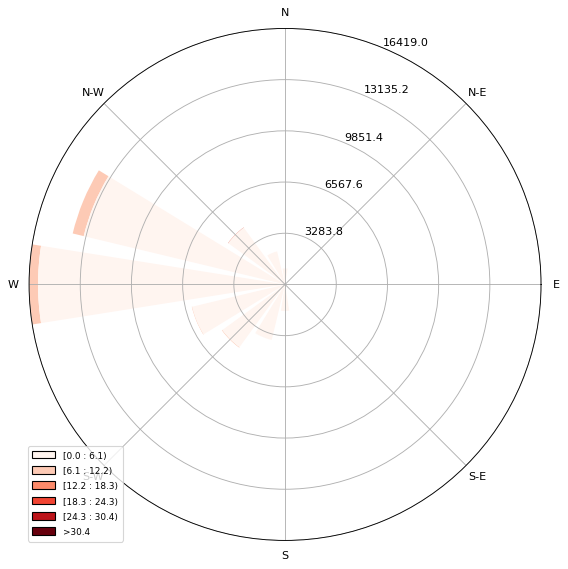

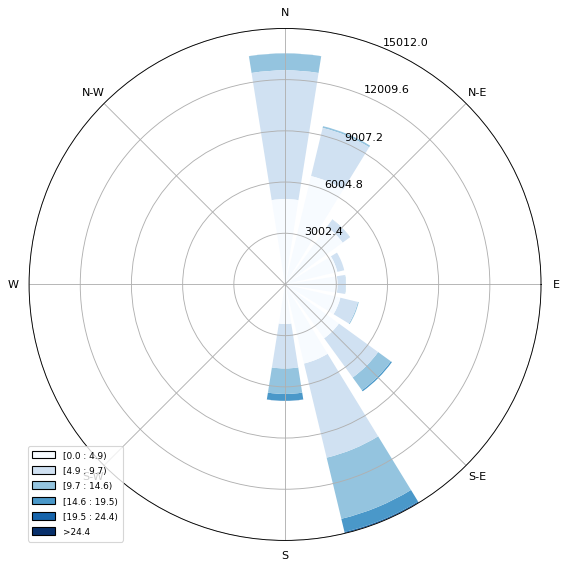

In [159]:
coast_angle = 90


def ang_diff(angle1 , coast_angle):
    diff = np.abs(angle1 - coast_angle)
    diff = np.where(diff > 180, 360 - diff, diff)
    return diff



diff_a_coast = xr.apply_ufunc(
    ang_diff,
    a['angle'],
    input_core_dims=[[]],
    vectorize=True,
    kwargs={'coast_angle': coast_angle},  # Pass the coast angle as a keyword argument
    dask='parallelized',
    output_dtypes=[np.float64],
)


diff_b_coast = xr.apply_ufunc(
    ang_diff,
    b['angle'],  # b['angle'] is a 2D array with shape (time, height)
    input_core_dims=[['time', 'height']],  # The first input is 2D, the second is scalar
    vectorize=True,  # Apply the function element-wise
    output_core_dims=[['time', 'height']],  # The output should have the same 2D shape
    dask='parallelized',  # Enable parallelization with Dask
    kwargs={'coast_angle': coast_angle + 180}, 
    output_dtypes=[np.float64],  # Specify output data type
)




a_within_90 = a.where(diff_a_coast > 90, drop=True)
b_within_180 = b.where(diff_b_coast > 90, drop=True)


draw_windrose(a_within_90,color=cm.Reds)
draw_windrose(b_within_180.mean(dim='height'),color=cm.Blues)




In [160]:
a_within_90

<xarray.Dataset> Size: 2MB
Dimensions:   (time: 54655)
Coordinates:
    height    float32 4B 4.0
  * time      (time) datetime64[ns] 437kB 2001-04-05 ... 2012-12-31T23:00:00
Data variables:
    bar_pres  (time) float32 219kB 101.1 101.1 101.0 101.0 ... 101.1 101.1 101.1
    temp      (time) float32 219kB 30.9 30.94 30.98 31.02 ... 30.79 30.83 30.87
    dp        (time) float32 219kB 25.03 25.09 25.14 25.2 ... 24.85 24.91 24.97
    rh        (time) float32 219kB 72.64 72.73 72.81 72.89 ... 72.4 72.48 72.56
    u_wind    (time) float32 219kB -2.316 -2.29 -2.264 ... -2.395 -2.369 -2.343
    v_wind    (time) float32 219kB 0.6723 0.595 0.5177 ... 0.9042 0.8269 0.7496
    angle     (time) float32 219kB 343.8 345.4 347.1 348.9 ... 339.3 340.8 342.3
    speed     (time) float32 219kB 2.412 2.366 2.322 2.281 ... 2.56 2.509 2.46
Attributes: (12/13)
    command_line:          idl -D 0 -R -n interpolatedsonde -s twp -f C1 -b 2...
    Conventions:           ARM-1.1
    process_version:       vap-interpolatedsonde-6.6-0.el6
    input_datastreams:     twpgriddedsondeC1.c0 : 2.2 : 20010403.000030-20010...
    dod_version:           interpolatedsonde-c1-4.0
    site_id:               twp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Tropical Western Pacific (TWP), Manus Island, Papu...
    datastream:            twpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               created by user ttoto on machine chalk at 2016-05-...

In [87]:
a_aligned , b_aligned = xr.align(a_within_90,b_within_180,join='inner')

In [102]:


def calc_SBI(a, b, cost_angle):
    # Explicitly add a new axis to 'a' to allow broadcasting over the height dimension
    # 'a' should have shape (27192, 1) to match the (27192, 75) shape of 'b'
    a_expanded = a[:, np.newaxis]  # This reshapes 'a' from (27192,) to (27192, 1)
    
    # Now 'a_expanded' can be broadcasted to (27192, 75)
    SBI = np.cos(np.radians(a_expanded - cost_angle)) * np.cos(a_expanded + 180 - b)
    return SBI

"""
SBI = xr.apply_ufunc(
    calc_SBI,
    a_within_90,
    b_within_180,
    input_core_dims=[['time'], ['time']],
    vectorize=True,
    dask='parallelized',
    
)
"""

SBI = xr.apply_ufunc(
    calc_SBI,
    a_aligned,  # Aligned dataset a (with time)
    b_aligned,  # Aligned dataset b (with time and height)
    input_core_dims=[['time'], ['time', 'height']],  # time for a, time and height for b
    output_core_dims=[['time', 'height']],  # Output has time and height dimensions
    kwargs={'cost_angle': cost_angle},  # Pass cost_angle as keyword argument
    vectorize=True,  # Vectorizing the operation over the time and height dimensions
    dask='parallelized',  # Enable parallelization with Dask
)


SBI['SBI_index'] = SBI['angle']


#SBI = np.cos(np.radians(a_within_90['angle'] - cost_angle)) * np.cos(a_within_90['angle'] + 180 - b_within_180['angle'])

#SBI_diurnal = SBI.groupby('time.hour').sum(dim='time').compute()

In [103]:


SBI_final = SBI['SBI_index'].max(dim='height').compute()


In [104]:
SBI_diurnal = SBI_final[SBI_final > 0].groupby('time.hour').mean(dim='time').compute()



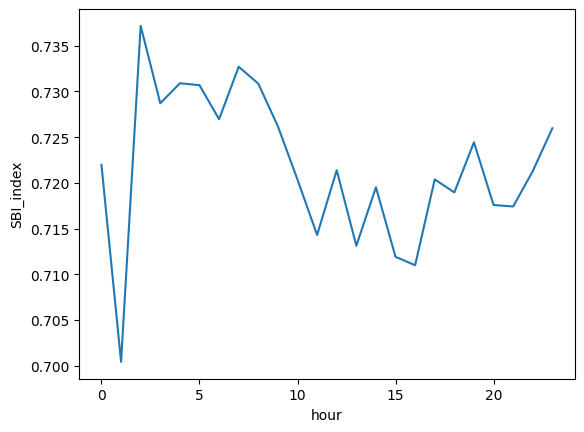

In [106]:
SBI_diurnal.plot()

In [ ]:
met_fol = '/home1/nalex2023/Datasets/met_manus/'

met_dft = create_dft(met_fol,arm_data=True)

#met_dft_2012 = met_dft[met_dft['datetime'].dt.month.isin([4,5,6])][met_dft['datetime'].dt.year == 2012]

met_dft_2012 = met_dft[met_dft['datetime'].dt.year == 2012]

met_dft_2012

,filepath,filename,datetime
15,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120904.000000.cdf,2012-09-04
21,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120201.000000.cdf,2012-02-01
65,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120912.000000.cdf,2012-09-12
85,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120217.000000.cdf,2012-02-17
105,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120928.000000.cdf,2012-09-28
...,...,...,...
6045,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120511.000000.cdf,2012-05-11
6047,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120818.000000.cdf,2012-08-18
6050,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120720.000000.cdf,2012-07-20
6074,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20121130.000000.cdf,2012-11-30


In [127]:


dset_met_manus = xr.open_mfdataset(met_dft_2012['filepath'].values, combine='by_coords',chunks='auto').sel(time=slice('2012-04-01','2012-06-30'))

In [136]:
surface_temp = dset_met_manus['temp_mean'].resample(time='1h').mean().roll(time=10)

In [137]:
SBI_high = SBI_final.where(SBI_final > 0, drop=True).sel(time=slice('2012-04-01','2012-06-30'))

time_highs = SBI_high.time

#temp_surface = dset['temp'].sel(height=2,method='nearest').sel(time=time_highs).compute()
temp_surface = surface_temp.sel(time=time_highs,method='nearest').compute()



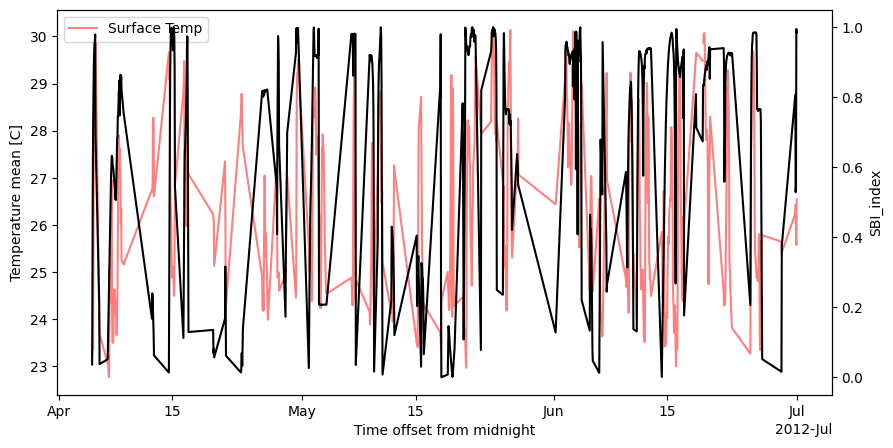

In [138]:
fig,ax = plt.subplots(1,1,figsize=(10,5))


ax2 = ax.twinx()

SBI_high.plot(ax=ax2, color='black', label='SBI > 0.8')
temp_surface.plot(ax=ax, color='red', label='Surface Temp',alpha=0.5)

ax.legend(loc='upper left')

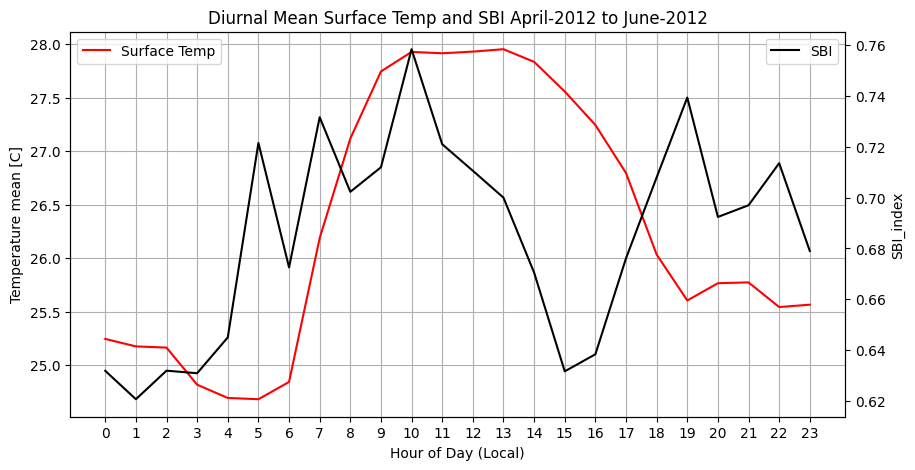

In [141]:
diurnal_surf_temp = temp_surface.groupby('time.hour').mean(dim='time').compute()

diurnal_sbi = SBI_high.groupby('time.hour').mean(dim='time').compute()


fig,ax = plt.subplots(1,1,figsize=(10,5))

ax2 = ax.twinx()

diurnal_surf_temp.plot(ax=ax, color='red', label='Surface Temp')

diurnal_sbi.plot(ax=ax2, color='black', label='SBI > 0.8')


new_dft = SBI_diurnal.to_dataframe().reset_index()

# add more tick labels on x axis 

ax.set_xticks(np.arange(0, 24, 1))
ax.set_xticklabels(np.arange(0, 24, 1), rotation=0)

ax.legend(['Surface Temp'],loc='upper left')
ax2.legend(['SBI'],loc='upper right')
ax.set_xlabel('Hour of Day (Local)')

ax.set_title('Diurnal Mean Surface Temp and SBI April-2012 to June-2012')
ax.grid()

In [37]:
new_dft_diurnal = new_dft.set_index('hour')

temp_dft = diurnal_surf_temp.to_dataframe().reset_index().set_index('hour')

new_dft_diurnal['temp'] = temp_dft['temp_mean']

final_cols = new_dft_diurnal.drop(columns=['height'])

final_cols.corr()

,angle,temp
angle,1.000000,-0.239812
temp,-0.239812,1.000000


In [ ]:
# lead lag correlation 

